In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchvision import models, transforms
import torch.nn as nn
import torch
import torch.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchmetrics import Accuracy
import numpy as np
import shap

# Dataset
Inspect dataset

In [3]:
class ImageDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="../data/images", batch_size=32, num_workers=4, transform=None, normalize=False, shuffle=True):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform
        self.data_dir = data_dir
        self.normalize = normalize
        self.shuffle = shuffle

    def setup(self, stage=None):
        # Define data transform
        train_transform = []
        if self.transform is not None:
            train_transform+=self.transform
        train_transform += [
                transforms.Resize(224),             # resize shortest side to 128 pixels
                transforms.CenterCrop(224),         # crop longest side to 128 pixels at center
                transforms.ToTensor()               # convert PIL image to tensor
        ]
        test_transform = [
                transforms.Resize(224),             # resize shortest side to 128 pixels
                transforms.CenterCrop(224),         # crop longest side to 128 pixels at center
                transforms.ToTensor()               # convert PIL image to tensor
        ]

        if self.normalize:
            normalize_fn = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            train_transform.append(normalize_fn)
            test_transform.append(normalize_fn)

        train_transform = transforms.Compose(train_transform)
        test_transform = transforms.Compose(test_transform)
        
        # Initialize train/test sets
        train_dataset = ImageFolder(self.data_dir, transform=train_transform)
        test_dataset = ImageFolder(self.data_dir, transform=test_transform)
        classes = train_dataset.find_classes(self.data_dir)[1]
        print(f"Loaded samples into dataset with label 'no'={classes['no']} and 'yes'={classes['yes']}")
        
        # Split dataset into train/test sets and stratify over labels to balance datasets with set seed 
        # DO NOT CHANGE THE SEED
        generator = torch.Generator().manual_seed(390397)
        train_len = int(0.8*len(train_dataset))
        test_len = int((len(train_dataset)-train_len)/2)
        train_dataset = random_split(
            dataset=train_dataset, 
            lengths=[train_len, test_len, test_len],
            generator=generator)[0]
        val_dataset, test_dataset = random_split(
            dataset=test_dataset, 
            lengths=[train_len, test_len, test_len],
            generator=generator)[1:]
        
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=self.shuffle)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

Loaded samples into dataset with label 'no'=0 and 'yes'=1


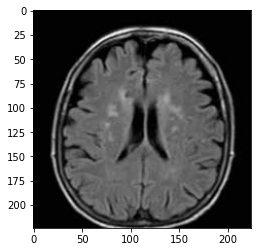

In [4]:
dm = ImageDataModule()
dm.setup()
images, labels = next(iter(dm.train_dataloader()))
plt.imshow(images[30].permute(1,2,0))
plt.show()

# Model

Initialize model

In [5]:
class CNNBaseline(pl.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        
        self.lr = lr

        self.save_hyperparameters()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False), # 64x64
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False), # 32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False), # 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False), # 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False), # 4x4
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False), # 2x2
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Sequential(
            nn.Linear(512, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 2),
        )

        self.optimizer = torch.optim.Adam
        self.criterion = nn.CrossEntropyLoss()

        self.train_acc = Accuracy()
        self.val_acc = Accuracy()
        self.test_acc = Accuracy()

    def forward(self, x):
        x = self.conv(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.fc(x)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        y_pred = torch.softmax(y_hat, 1)
        self.train_acc(y_pred, y)
        self.log("train_loss", loss)
        self.log("train_acc", self.train_acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        y_pred = torch.softmax(y_hat, 1)
        self.val_acc(y_pred, y)
        self.log("val_loss", loss)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        y_pred = torch.softmax(y_hat, 1)
        self.test_acc(y_pred, y)
        self.log("test_loss", loss)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), lr=self.lr)
        return optimizer

class CNNTransferLearning(pl.LightningModule):
    def __init__(self, lr=0.001, use_pretrained=True):
        super().__init__()
        
        self.lr = lr

        self.save_hyperparameters()

        base_model = models.resnet18(pretrained=use_pretrained)
        in_features = base_model.fc.in_features
        layers = list(base_model.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        self.fc = nn.Linear(in_features, 2)
        self.optimizer = torch.optim.Adam
        self.criterion = nn.CrossEntropyLoss()

        self.train_acc = Accuracy()
        self.val_acc = Accuracy()
        self.test_acc = Accuracy()

    def forward(self, x):
        self.feature_extractor.eval()
        with torch.no_grad():
            x = self.feature_extractor(x)
            x = torch.flatten(x, 1)
        logits = self.fc(x)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        y_pred = torch.softmax(y_hat, 1)
        self.train_acc(y_pred, y)
        self.log("train_loss", loss)
        self.log("train_acc", self.train_acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        y_pred = torch.softmax(y_hat, 1)
        self.val_acc(y_pred, y)
        self.log("val_loss", loss)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        y_pred = torch.softmax(y_hat, 1)
        self.test_acc(y_pred, y)
        self.log("test_loss", loss)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), lr=self.lr)
        return optimizer

# Training
Train the model and evaluate its performance on the test set

In [14]:
model = CNNTransferLearning()
transform = [transforms.RandomHorizontalFlip(), transforms.RandomRotation(90)]
dm = ImageDataModule(normalize=True, transform=transform)
trainer = pl.Trainer(max_epochs=200, log_every_n_steps=5)
trainer.fit(model, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 11.2 M
1 | fc                | Linear           | 1.0 K 
2 | criterion         | CrossEntropyLoss | 0     
3 | train_acc         | Accuracy         | 0     
4 | val_acc           | Accuracy         | 0     
5 | test_acc          | Accuracy         | 0     
-------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Loaded samples into dataset with label 'no'=0 and 'yes'=1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [17]:
load_model = True
checkpoint = "lightning_logs/baseline_with_augmentation/checkpoints/epoch=199-step=1400.ckpt"
if load_model:
    model = CNNBaseline.load_from_checkpoint(checkpoint)

model.eval()
trainer.test(model, datamodule=dm)

Loaded samples into dataset with label 'no'=0 and 'yes'=1


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    1.0
        test_loss          0.024723542854189873
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.024723542854189873, 'test_acc': 1.0}]

# SHAP Values
Compute the shapley values and visualize the results

In [44]:
def normalize_images(imgs):
    return transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(imgs)

dm = ImageDataModule(batch_size=128)
dm.setup()
train_batch = next(iter(dm.train_dataloader()))
train_images, _ = train_batch

test_batch = next(iter(dm.test_dataloader()))
test_images, test_labels = test_batch
test_images_no = []
test_images_yes = []
for img, l in zip(test_images, test_labels):
    if l>0:
        test_images_no.append(img)
    else:
        test_images_yes.append(img)
test_images_no = torch.stack(test_images_no, dim=0)
test_images_yes = torch.stack(test_images_yes, dim=0)
print(test_images_no.shape, test_images_yes.shape)

Loaded samples into dataset with label 'no'=0 and 'yes'=1
torch.Size([16, 3, 224, 224]) torch.Size([12, 3, 224, 224])


In [ ]:
test_images = torch.cat(test_images_no[:1], test_images_yes[:1])
background = train_images[:100]

e = shap.DeepExplainer(model, normalize_images(background))
shap_values = e.shap_values(normalize_images(test_images))

In [43]:
test_images_no = []
test_images_yes = []
for img, l in zip(test_images, test_labels):
    if l>0:
        test_images_no.append(img)
    else:
        test_images_yes.append(img)
test_images_no = torch.stack(test_images_no, dim=0)
test_images_yes = torch.stack(test_images_yes, dim=0)
print(test_images_no.shape, test_images_yes.shape)

torch.Size([2, 3, 224, 224]) torch.Size([1, 3, 224, 224])


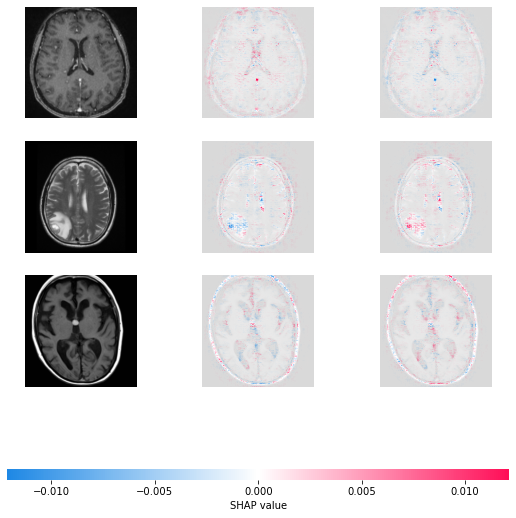

In [34]:
shap_numpy = [np.transpose(sv, (0,2,3,1)) for sv in shap_values]
test_numpy = np.transpose(test_images.numpy(), (0,2,3,1))

# plot the feature attributions
shap.image_plot(shap_numpy, test_numpy)